# Recurrent Neural Networks

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Sequential models

We can use a simple sequence model where we look at the last $\tau$ instances to predict the next instance in the sequence. 

This is the Markov chain model

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, \dots, y^{(t-\tau-1)}, y^{(t-\tau)})$

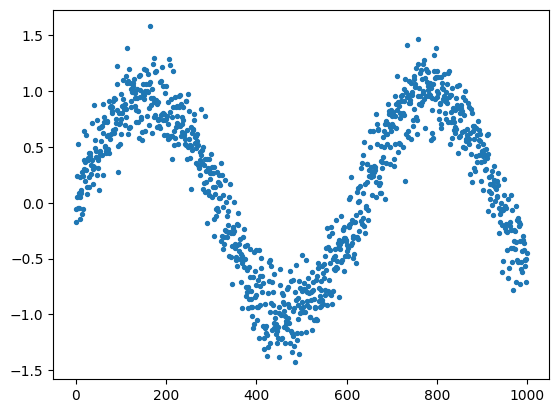

In [3]:
N = 1000
x = torch.arange(0, N, 1)
y = torch.sin(0.01 * x) + torch.normal(0, 1, size=(N,)) * 0.2

plt.scatter(x, y, s=8)

In [4]:
from torch.utils.data import DataLoader
from torch.optim import SGD

class LinearRegression(nn.Module):
    def __init__(self, alpha=0.1, batch_size=32, epochs=10, eta=0.01) -> None:
        super().__init__()
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.eta = eta
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
        self.losses = None
    
    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        
        optim = SGD(self.net.parameters(), self.eta, weight_decay=self.alpha)

        training_set = torch.cat([X, y.reshape(-1, 1)], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            
            batch_loss = []
            for batch in train_dataloader:
                train_X = batch[:, :-1]
                train_y = batch[:, -1].reshape(-1, 1)

                y_hat = self.net(train_X)

                loss = self.loss(y_hat, train_y)
                batch_loss.append(loss.item())

                loss.backward()
                optim.step()
                optim.zero_grad()
                
            self.losses.append(sum(batch_loss) / len(batch_loss))

        return self
    
    def predict(self, X: torch.Tensor):
        return torch.matmul(X, self.w) + self.b

Using a linear regression we can model a sequence with the length of the context history $\tau=3$

C:\Users\janba\python-dev\deeplearning_notebooks\venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


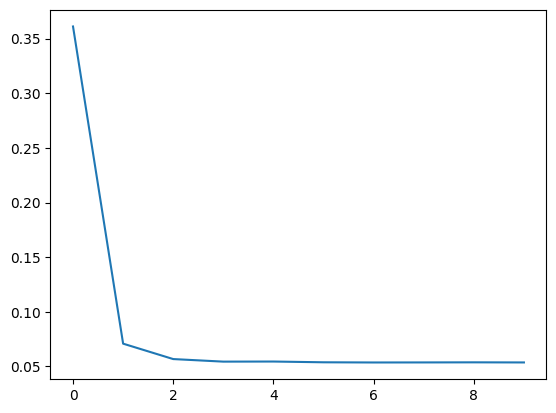

In [6]:
tau = 3
x_train = torch.cat([y[i : i + tau][None, :] for i in range(N-tau)], dim=0)
y_train = torch.cat([y[i+tau][None] for i in range(N-tau)])

model = LinearRegression(batch_size=16, epochs=10)
model.fit(x_train, y_train)

plt.plot(model.losses)

We can see that looking 1 step into the future leads to a good model

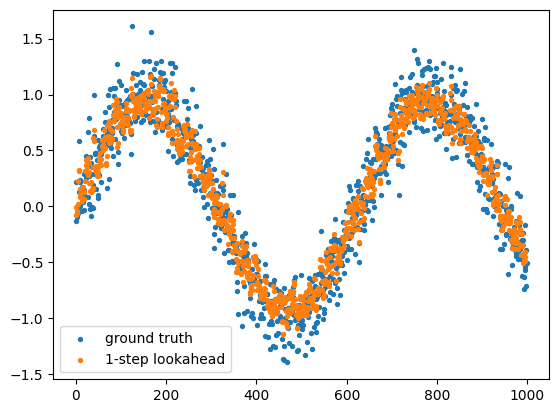

In [16]:
y_pred = model(x_train)
plt.scatter(x, y, s=8, label='ground truth')
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8, label='1-step lookahead')
plt.legend()

However, a big problem is that looking further into the future leads to cumulative error that is accumulated, which causes bad predictions.

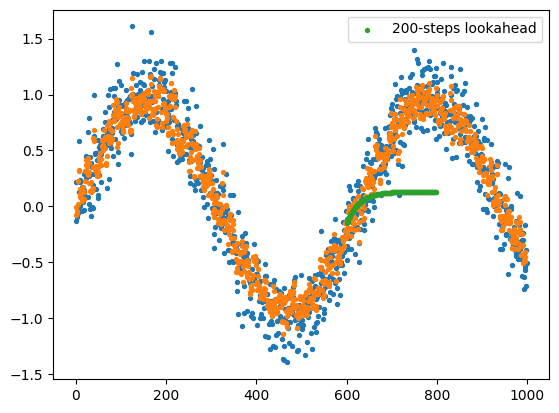

In [17]:
def look_k_steps_into_future(model, k, x_instance):
    for _ in range(k):
        y_pred = model(x_instance).detach()
        x_instance = torch.cat([x_instance[1:], y_pred])
    return model(x_instance).detach()

steps = 200
look_into_future = [look_k_steps_into_future(model, i, x_train[600]).item() for i in range(1, steps)]
plt.scatter(x, y, s=8)
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8)
plt.scatter(range(600, 600+steps-1), look_into_future, s=8, label=f'{steps}-steps lookahead')
plt.legend()

## Basic RNN module

Maps input sequence to output sequence using update equations for each time step $t=1$ to $t = \tau$
\begin{align*}
    \textbf{a}^{(t)} &= \textbf{b} + \textbf{W}\textbf{h}^{(t-1)} + \textbf{U}\textbf{x}^{(t)}\\
    \textbf{h}^{(t)} &= \text{tanh}(\textbf{a}^{(t)})\\
    \textbf{\hat{y}}^{(t)} &= \text{softmax}(\textbf{c} + \textbf{V}\textbf{h}^{(t)})
\end{align*}
for 
- shared bias vectors $\textbf{b}, \textbf{c}$
- shared weight matrices:
  - $\textbf{W}$: hidden-to-hidden weights
  - $\textbf{U}$: input-to-hidden
  - $\textbf{V}$: hidden-to-output
- and input vectors $\textbf{x} \in \textbf{X}$

In [36]:
class RNNScratch(nn.Module):
    def __init__(self, num_inputs: int, num_hidden: int, num_outputs: int) -> None:
        super().__init__()
        self.b = nn.Parameter(torch.zeros((num_hidden, ), device='cuda'))
        self.W = nn.Parameter(torch.randn((num_hidden, num_hidden), device='cuda'))
        self.U = nn.Parameter(torch.randn((num_inputs, num_hidden), device='cuda'))
        
        self.c = nn.Parameter(torch.randn((num_outputs, ), device='cuda'))
        self.V = nn.Parameter(torch.randn((num_hidden, num_outputs), device='cuda'))
        
    def forward(self, inputs: torch.Tensor, h: torch.Tensor=None):
        if h is not None: 
            h, = h
        out = []        
        for X in inputs: # shape of inputs: (num_seq_steps, batch_size, num_inputs)
            a = self.b + X @ self.U + (h @ self.W if h is not None else 0)
            h = F.tanh(a)
            out.append(F.softmax(self.c + h @ self.V, dim=0))

        return out

### Gradient clipping function

In [39]:
def clip_gradients(clip_val: float, model: nn.Module):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sum(sum(torch.sum(p.grad**2) for p in params))
    if norm > clip_val:
        for p in params:
            p.grad[:] *= clip_val / norm

In [22]:
rnn = RNNScratch(num_inputs=27, num_hidden=80, num_outputs=5)
X_test = torch.ones((4, 32, 27)).to('cuda')
out = rnn(X_test)
out[-1].shape

torch.Size([32, 5])

## Sequence Dataset

- X: sequence of one-hot vectors of either characters or words
- Y: same sequence but shifted to the right by 1

Usage: language model that predicts the next token based on context window `seq_len`

### Character level dataset

In [40]:
from torch.utils.data import DataLoader, Dataset
import re

class SeqCharacterDataset(Dataset):
    def __init__(self, file_path, seq_len=3) -> None:
        f = open(file_path, 'r')
        corpus = f.read()
        corpus = re.sub('[^A-Za-z]+', ' ', corpus).lower()

        self.unique_chars = np.unique(list(''.join(corpus)))
        self.encoding = {k:np.eye(len(self.unique_chars))[i] for i, k in enumerate(self.unique_chars)}

        X = []
        Y = []
        for i in range(len(corpus)-seq_len):       
            x = [self.encoding[c] for c in corpus[i:i+seq_len]]
            y = [self.encoding[c] for c in corpus[i+1:i+seq_len+1]]
            X.append(x)
            Y.append(y)

        X = torch.tensor(np.array(X, dtype='float32'), device='cuda')
        Y = torch.tensor(np.array(Y, dtype='float32'), device='cuda')
        self.data = torch.cat([X, Y], dim=1)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [41]:
seq_len = 3
dataset = SeqCharacterDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

next(iter(dataloader)).shape

torch.Size([16, 6, 27])

### Word level dataset

In [42]:
from torch.utils.data import DataLoader, Dataset
import re

class SeqWordDataset(Dataset):
    def __init__(self, file_path, seq_len=3) -> None:
        f = open(file_path, 'r')
        corpus = f.read()
        corpus = re.sub('[^A-Za-z]+', ' ', corpus).lower().split()

        self.unique_words = np.unique(corpus)
        self.encoding = {k:np.eye(len(self.unique_words))[i] for i, k in enumerate(self.unique_words)}
        
        X = []
        Y = []
        for i in range(len(corpus)-seq_len):       
            x = [self.encoding[w] for w in corpus[i:i+seq_len]]
            y = [self.encoding[w] for w in corpus[i+1:i+seq_len+1]]
            X.append(x)
            Y.append(y)

        X = torch.tensor(np.array(X, dtype='float32'), device='cuda')
        Y = torch.tensor(np.array(Y, dtype='float32'), device='cuda')
        self.data = torch.cat([X, Y], dim=1)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [43]:
seq_len = 3
dataset = SeqWordDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

next(iter(dataloader)).shape

torch.Size([16, 6, 521])

## Testing RNN from scratch

### Character level language model

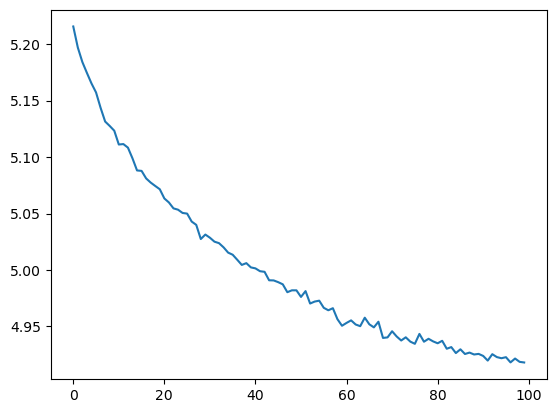

In [17]:
seq_len = 3
dataset = SeqCharacterDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = len(dataset.unique_chars)
rnn = RNNScratch(num_inputs=n_input, num_hidden=80, num_outputs=n_input)

opt = torch.optim.SGD(rnn.parameters(), 0.05)

losses = []

for i in range(100):
    batch_loss = []
    for batch in dataloader:
        batch_X = batch[:, :seq_len].transpose(0, 1)
        batch_y = batch[:, seq_len:].transpose(0, 1)
        
        opt.zero_grad()
        out = rnn(batch_X)
        y_pred = torch.stack(out, dim=0)
        loss = F.cross_entropy(y_pred, batch_y)
        
        loss.backward()
        clip_gradients(10, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item())
    
    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [18]:
losses

[5.215589481314229,
 5.196933112613896,
 5.184093028152545,
 5.174450570437575,
 5.165166853623069,
 5.157190725593369,
 5.143582446587518,
 5.131434911273304,
 5.127537375287071,
 5.123331262657679,
 5.1111026749092066,
 5.111486809241339,
 5.1083399310630835,
 5.098866996369831,
 5.088148280128914,
 5.087757340366976,
 5.081077339735674,
 5.077400279168638,
 5.074394772089825,
 5.071481988837682,
 5.0633410715686225,
 5.059795830533912,
 5.054571754574158,
 5.053401858077765,
 5.050512258252949,
 5.04993978683195,
 5.042887170080077,
 5.03997445724171,
 5.027430307062179,
 5.031378862153681,
 5.028593931791078,
 5.025091669102407,
 5.023771150124506,
 5.020073349611747,
 5.015406835882157,
 5.013529997415493,
 5.00908531673214,
 5.004510956107026,
 5.0060850103902075,
 5.0023207392717275,
 5.001439860447701,
 4.99894432206228,
 4.998405430601051,
 4.990907528239829,
 4.990784605550025,
 4.989238236234596,
 4.9873339252768405,
 4.98036605088822,
 4.982025314489177,
 4.982005278681227,

### Word level language model

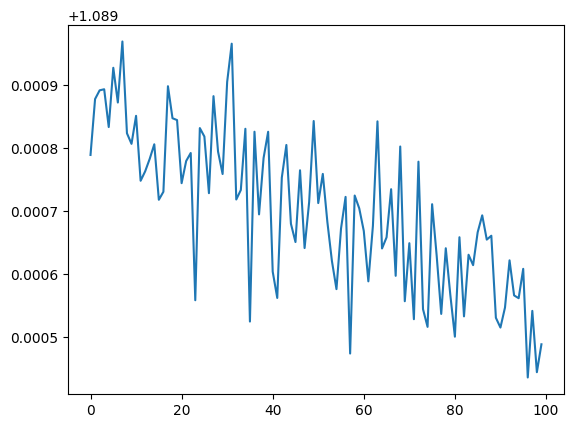

In [27]:
seq_len = 3
dataset = SeqWordDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = len(dataset.unique_words)
rnn = RNNScratch(num_inputs=n_input, num_hidden=100, num_outputs=n_input)

opt = torch.optim.SGD(rnn.parameters(), 0.1)

losses = []

for i in range(100):
    batch_loss = []
    for batch in dataloader:
        batch_X = batch[:, :seq_len].transpose(0, 1)
        batch_y = batch[:, seq_len:].transpose(0, 1)
        
        opt.zero_grad()
        out = rnn(batch_X)
        y_pred = torch.stack(out, dim=0)
        loss = F.cross_entropy(y_pred, batch_y)
        
        loss.backward()
        clip_gradients(10, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item()) # perplexity metric
    
    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [34]:
x_test = ["and", "the", "cold"]
x_test = torch.tensor(np.array([dataset.encoding[x] for x in x_test], dtype='float32'), device='cuda')

out = rnn(x_test[None, :])
y_pred = torch.stack(out, dim=0)

y_pred.shape
indices = y_pred.argmax(dim=2)

dataset.unique_words[indices.cpu().detach().numpy()]

array([['resting', 'structure', 'been']], dtype='<U15')

## RNN with Pytorch primitives

In [44]:
class RNN(nn.Module):
    def __init__(self, num_inputs: int, num_hidden: int, num_outputs: int) -> None:
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hidden)
        self.out = nn.Sequential(nn.LazyLinear(num_outputs), nn.Softmax(dim=1))
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        output, H = self.rnn(X, H)
        return self.out(output).swapaxes(0, 1), H

    def predict(self, prefix: str, num_preds: int, encoding, unique_vals):
        prefix = prefix.lower().split() if len(max(unique_vals.tolist(), key=lambda x: len(x))) > 1 else list(prefix.lower())
        H, outputs = None, [torch.tensor(encoding[prefix[0]].reshape(1, -1), dtype=torch.float32).to('cuda')]

        for i in range(len(prefix) + num_preds - 1):
            # print(outputs[-1].shape)
            Y, H = self.forward(outputs[-1], H)
            # print(Y.shape, H.shape)

            if i < len(prefix) - 1:
                outputs.append(torch.tensor(encoding[prefix[i+1]].reshape(1, -1), dtype=torch.float32).to('cuda'))
            else:
                outputs.append(Y.reshape(1, -1))
        
        return ' '.join([unique_vals[y.cpu().argmax(dim=1)] for y in outputs])

### Character level model

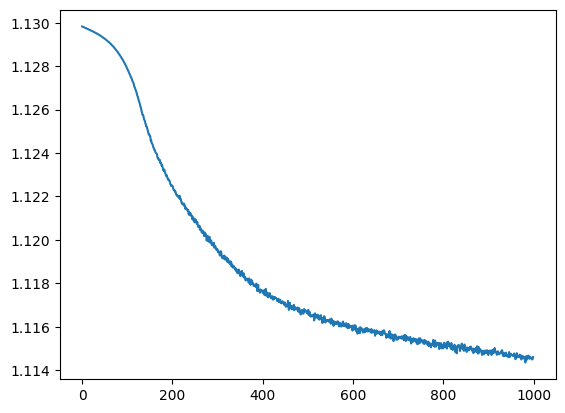

In [46]:
seq_len = 3
dataset = SeqCharacterDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = len(dataset.unique_chars)
rnn = RNN(num_inputs=n_input, num_hidden=200, num_outputs=n_input).to('cuda')

opt = torch.optim.SGD(rnn.parameters(), 0.1)

losses = []

for i in range(1000):
    batch_loss = []
    for batch in dataloader:
        batch_X = batch[:, :seq_len].transpose(0, 1)
        batch_y = batch[:, seq_len:]
        
        opt.zero_grad()
        y_pred, _ = rnn(batch_X)
        loss = F.cross_entropy(y_pred, batch_y)

        loss.backward()
        clip_gradients(1, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item()) # perplexity metric

    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [45]:
preds = rnn.predict("the ", 20, dataset.encoding, dataset.unique_chars)
preds

AttributeError: 'RNNScratch' object has no attribute 'predict'

### Word level model 

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


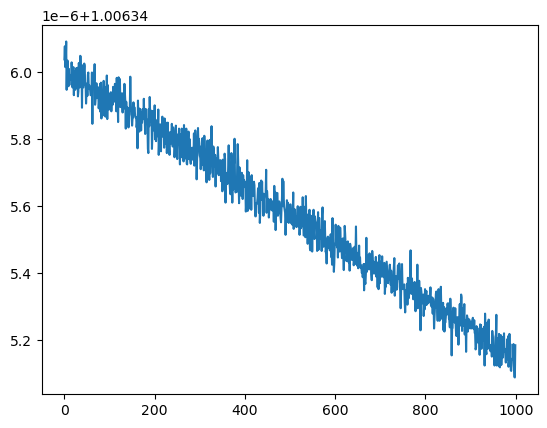

In [82]:
seq_len = 3
dataset = SeqWordDataset("../datasets/1984chapter.txt", seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = len(dataset.unique_words)
rnn = RNN(num_inputs=n_input, num_hidden=200, num_outputs=n_input).to('cuda')

opt = torch.optim.SGD(rnn.parameters(), 0.1)

losses = []

for i in range(1000):
    batch_loss = []
    for batch in dataloader:
        batch_X = batch[:, :seq_len].transpose(0, 1)
        batch_y = batch[:, seq_len:]
        
        opt.zero_grad()
        y_pred, _ = rnn(batch_X)
        # print(y_pred.shape, batch_y.shape)
        loss = F.cross_entropy(y_pred, batch_y)
        # break
        
        loss.backward()
        # clip_gradients(10, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item()) # perplexity metric
    # break
    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [83]:
preds = rnn.predict("the", 20, dataset.encoding, dataset.unique_words)
preds

'the guesswork colonies do do do do do do do do do do do do do do do do do do'

## Sequence to character RNN model

In [44]:
from torch.utils.data import DataLoader, Dataset
import re

class Vocab:
    def __init__(self, corpus: str) -> None:
        self.freqs = dict(zip(*np.unique(list(corpus.lower()), return_counts=True)))
        self.itos = np.unique(list(corpus) + ['.'])
        self.emb_size = self.itos.shape[0]
        self.emb = {k : i for i, k in enumerate(self.itos)}

class VocabDataset(Dataset):
    def __init__(self, file_path: str, seq_len=3) -> None:
        super().__init__()
        self.seq_len = seq_len
        f = open(file_path, 'r')
        self.corpus = f.read().lower()
        self.corpus = re.sub('[^A-Za-z]+', ' ', self.corpus)
        self.vocab = Vocab(self.corpus)

        self.corpus = self.corpus.split()

        self.X = []
        self.Y = []
        for w in self.corpus:
            context = [self.vocab.emb['.']]*seq_len
            for c in w + '.':
                ix = self.vocab.emb[c]
                self.X.append(context)
                self.Y.append(ix)
                context = context[1:] + [ix]
                
        self.X = torch.tensor(self.X)
        self.Y = torch.tensor(self.Y)
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.Y)


class RNN2char(nn.Module):
    def __init__(self, num_inputs: int, num_hidden: int, num_outputs: int) -> None:
        super().__init__()
        self.out_size = num_outputs
        self.num_inputs = num_inputs
        self.rnn = nn.RNN(num_inputs, num_hidden)
        self.out = nn.Sequential(nn.Linear(num_hidden, num_outputs), nn.Softmax(dim=2))
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        inputs = F.one_hot(X, num_classes=self.num_inputs).type(torch.float32)
        outputs, H = self.rnn(inputs, H) # input: (seq_len, batch_size, emb_size)
        return self.out(H), H

    def predict(self, prefix: str, num_preds: int, vocab: Vocab):
        prefix = list(prefix.lower())
        H, outputs = None, [vocab.emb[prefix[0]]]

        for i in range(len(prefix) + num_preds - 1):
            # print(outputs[-1].shape)
            Y, H = self.forward(torch.tensor(outputs[-1]).view(1, 1).to('cuda'), H)
            # print(Y.shape, H.shape)

            if i < len(prefix) - 1:
                outputs.append(vocab.emb[prefix[i+1]])
            else:
                outputs.append(Y.argmax(dim=2).item())
        
        return ''.join([vocab.itos[y] for y in outputs])

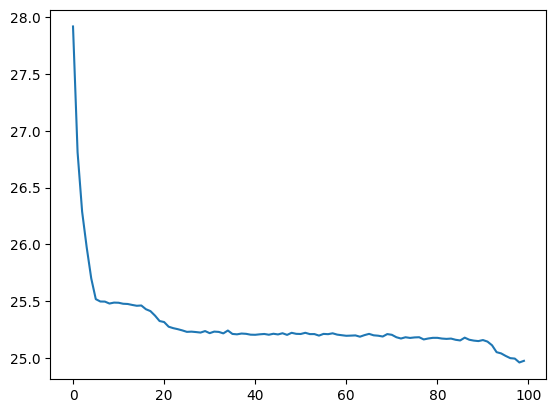

In [45]:
seq_len = 3
dataset = VocabDataset("../datasets/pokemon_names.txt", seq_len=seq_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

n_input = dataset.vocab.emb_size
rnn = RNN2char(num_inputs=n_input, num_hidden=200, num_outputs=n_input).to('cuda')

opt = torch.optim.SGD(rnn.parameters(), 0.1)

losses = []

for i in range(100):
    batch_loss = []
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to('cuda'), F.one_hot(batch_y, num_classes=n_input).type(torch.float32).to('cuda')
        
        opt.zero_grad()
        y_pred, _ = rnn(batch_X.T)
        # print(y_pred.view(-1, n_input).shape, batch_y.shape)
        loss = F.cross_entropy(y_pred.view(-1, n_input), batch_y)
        # break
        
        loss.backward()
        # clip_gradients(10, rnn)
        opt.step()

        batch_loss.append(torch.exp(loss.detach()).item()) # perplexity metric
    # break
    losses.append(np.sum(batch_loss) / len(batch_loss))

plt.plot(losses)

In [83]:
rnn.predict('charizard', 20, dataset.vocab)

'charizard....................'